# Short demo
In this demo, I run the code on three sample fluorescence images from Sweeney and Hochgreb's paper ["Autonomous extraction of optimal flame fronts in OH planar laser-induced fluorescence images"](https://opg.optica.org/ao/fulltext.cfm?uri=ao-48-19-3866&id=183266) (2019).
\
\
These images are binarized using Otsu's method, first using OpenCV's built-in capabilities, and then using my personal implementation.
\
\
It turns out this is equivalent to running the k-means clustering algorithm on the image histogram, with $k = 2$ clusters. The loss functions are in fact identical in the binary context. The optimal (Otsu) threshold $k$ can be written as:
\begin{align}
k &= \underset{k \in [0, 255]}{\text{argmax}} \,\, \underbrace{(\omega_{k\leq i}) (\omega_{k>i}) (\mu_{k\leq i} - \mu_{k>i})^2)}_{\text{inter-class variance}}\\
&= \underset{k \in [0, 255]}{\text{argmin}}\,\,\underbrace{(\omega_{k\leq i} \sigma_{k\leq i}^2) + (\omega_{k>i} \sigma_{k>i}^2)}_{\text{intra-class variance}}\\
&= \underset{k \in [0, 255]}{\text{argmin}}\,\, \frac{1}{\text{card}(N)} \sum_{c=0}^{c=1} || x_{j,c} - \bar{x}_{c} ||^2_2;\,\, \{x_{j,0}\} \sim \{x\,|\,x \leq k\}\,\text{and}\, \{x_{j,1}\} \sim \{x\,|\,x > k\}\\
&\sim \underset{k \in [0, 255]}{\text{argmin}}\,\, \underbrace{\sum_{c=0}^{c=1} || x_{j,c} - \bar{x}_{c} ||^2_2}_{\text{inertia}};\,\, \{x_{j,0}\} \sim \{x\,|\,x \leq k\}\,\text{and}\, \{x_{j,1}\} \sim \{x\,|\,x > k\}
\end{align}
where $\omega$ is the proportion of pixels (observations) in the provided range of intensities $i$, $N$ is the number of pixels (observations) in the image, $c = \{0,1\}$ is the cluster  (class) label (i.e., foreground vs. background), and $x$ are individual intensity values (single feature space), and $j \in [0,N]$ is the index of the observation.
\
\
Thus, it turns out the binary discriminant criterion proposed by [Otsu (1979)](https://ieeexplore.ieee.org/document/4310076) is nothing but a special case of the k-means algorithm for $k=2$ originally proposed by [MacQueen (1967)](https://books.google.co.uk/books?hl=en&lr=&id=IC4Ku_7dBFUC&oi=fnd&pg=PA281&dq=related:NfMlILJJH88J:scholar.google.com/&ots=nQVgC-ObtP&sig=Ci0RxETPxwKxHViD3j5GXDezdlU&redir_esc=y#v=onepage&q&f=false) more than 10 years earlier!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from otsu_segmentation import otsu
from sklearn.cluster import KMeans
import time

/Users/oussamachaib/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Plotting settings
fnt = 10 # Font size
y_label_loc = [10,20,20] # Y label coordinate for plotting
x_label_loc = [5,10,10] # X label coordinate location
plt.rcParams['text.usetex'] = True # TeX font
plt.rcParams['font.family'] = 'serif' # Serif type
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}' # AMS-LaTeX package
cMap = 'magma' # Colormap

----------------
Image 1
----------------
OpenCV implementation : Otsu threshold = 92 (elapsed time = 9e-05 s)
k-means : Threshold = 92 (elapsed time = 0.03)
Personal implementation : Otsu threshold = 92 (elapsed time = 0.01 s)


----------------
Image 2
----------------
OpenCV implementation : Otsu threshold = 104 (elapsed time = 8e-05 s)
k-means : Threshold = 104 (elapsed time = 0.04)
Personal implementation : Otsu threshold = 104 (elapsed time = 0.03 s)


----------------
Image 3
----------------
OpenCV implementation : Otsu threshold = 71 (elapsed time = 7e-05 s)
k-means : Threshold = 71 (elapsed time = 0.05)
Personal implementation : Otsu threshold = 71 (elapsed time = 0.03 s)




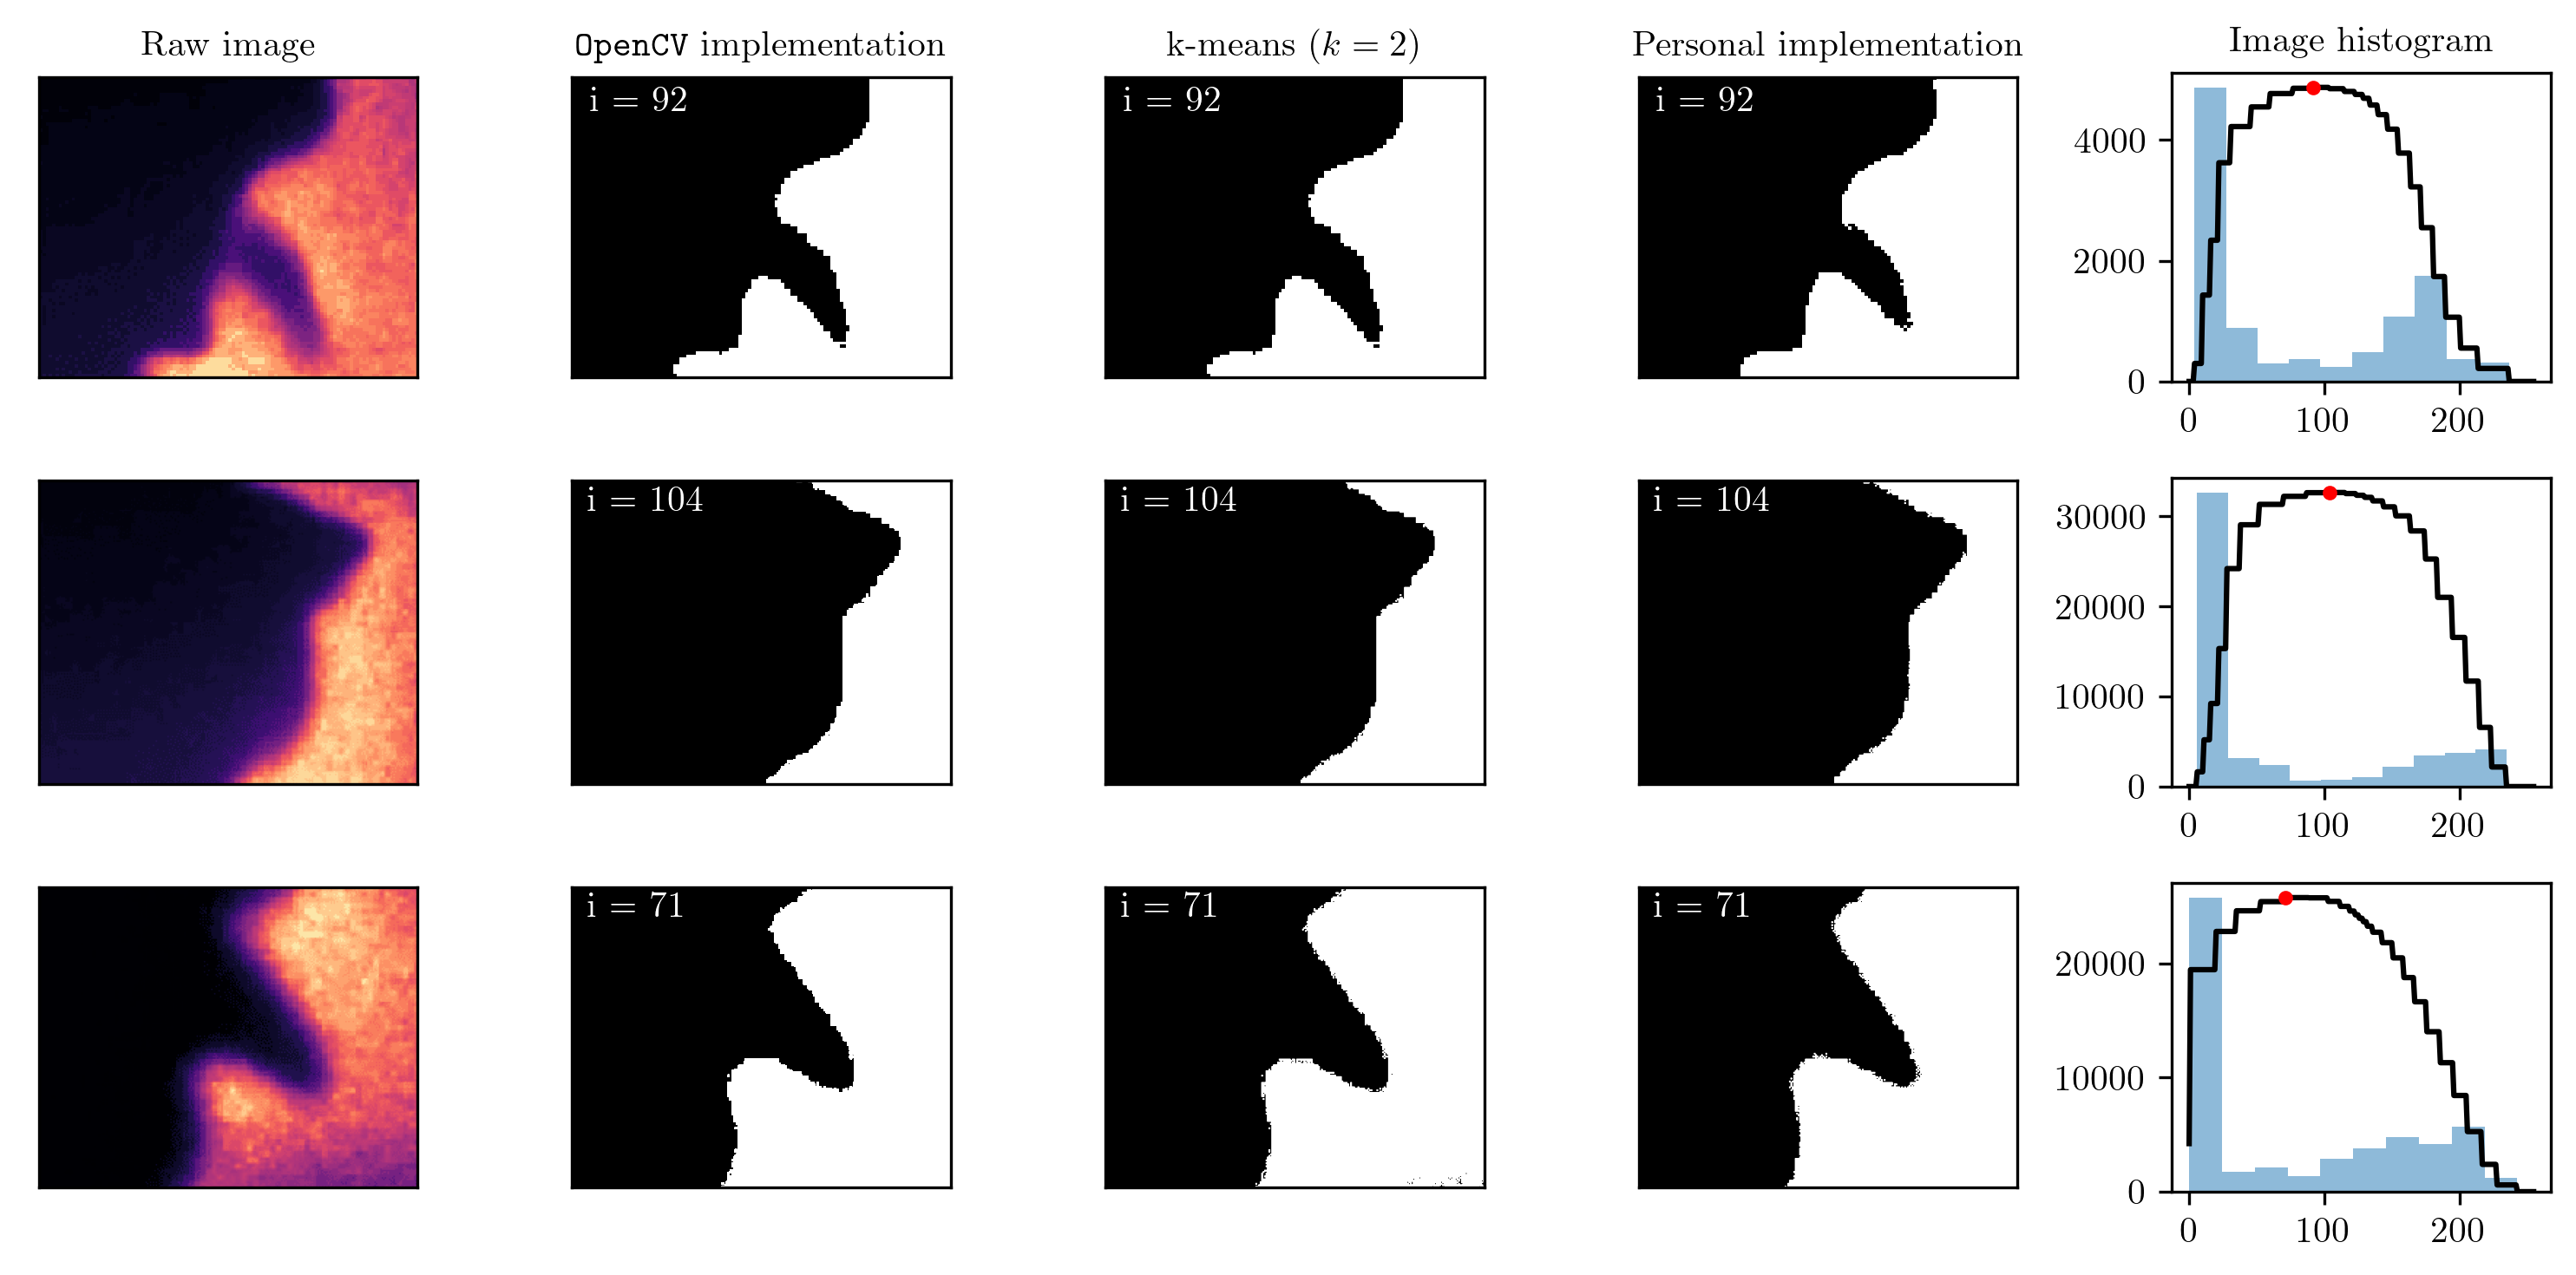

In [20]:
# Creating figure
fig = plt.figure(figsize = (10,5), dpi = 300)

counter = 1
for img_id in [1,2,3]:
    # Loading the single-channel image
    img = cv2.imread(f"demo_images/demo{img_id}.png",cv2.IMREAD_GRAYSCALE)
    
    # Plotting the raw image
    ax = fig.add_subplot(3,5,counter)
    ax.imshow(img, cmap=cMap, vmin=0, vmax=255)
    ax.set_xticks([])
    ax.set_yticks([])
    if img_id == 1:
        plt.title('Raw image', fontsize = fnt)
    counter += 1
    
    # Thresholded image (using OpenCV's implementation)
    ax = fig.add_subplot(3,5,counter)
    start = time.time()
    cv2_otsu_threshold, img1 = cv2.threshold(img,0,255,cv2.THRESH_OTSU)
    end = time.time()
    time_cv2 = end - start
    ax.imshow(img1, cmap='gray', vmin=0, vmax=.5)
    ax.set_xticks([])
    ax.set_yticks([])
    if img_id == 1:
        plt.title(r'\texttt{OpenCV} implementation', fontsize = fnt)
    counter += 1
    ax.text(x_label_loc[img_id-1],y_label_loc[img_id-1], f'i = {int(cv2_otsu_threshold)}', fontsize = fnt, color = 'w')
    
    # K-means clustering (with k = 2)
    I = img.astype(int).ravel()
    X = np.column_stack((I,np.zeros(I.shape))) # k-means requires at least 2 predictors, so adding a dimension of zeros the job
    start = time.time()
    model = KMeans(n_clusters = 2, random_state = 0)
    model.fit(X)
    pred = model.labels_.astype(int)
    end = time.time()
    time_km = end - start
    # The exact binary integer (0 or 1) will vary since kmeans treats it as a cluster label (the 0/1 label is agnostic to intensities in the original image)
    # This small fix ensures the darker region of the binary image is assigned 0's
    if np.mean(I[pred==0])>np.mean(I[pred==1]):
        pred = 1 - pred
    kmeans_threshold = np.max(I[pred==0])
    pred = pred.reshape((img.shape))
    ax = fig.add_subplot(3,5,counter)
    ax.imshow(pred, cmap='gray', vmin=0, vmax=.5)
    ax.set_xticks([])
    ax.set_yticks([])
    if img_id == 1:
        plt.title('k-means ($k = 2$)', fontsize = fnt)
    counter += 1
    ax.text(x_label_loc[img_id-1],y_label_loc[img_id-1], f'i = {kmeans_threshold}', fontsize = fnt, color = 'w')
    
    # Personal implementation
    ax = fig.add_subplot(3,5,counter)
    start = time.time()
    model = otsu()
    model.fit(img)
    binary_image = model.predict(img)
    end = time.time()
    time_personal = end - start
    ax.imshow(binary_image, cmap='gray', vmin=0, vmax=.5)
    ax.set_xticks([])
    ax.set_yticks([])
    if img_id == 1:
        plt.title('Personal implementation', fontsize = fnt)
    counter += 1
    ax.text(x_label_loc[img_id-1],y_label_loc[img_id-1], f'i = {model.threshold}', fontsize = fnt, color = 'w')
    
    # Histogram
    ax = fig.add_subplot(3,5,counter)
    n, _ , _ =ax.hist(img.ravel(), bins = 10, alpha = .5, density = False)
    ax.plot(model.scan['i'], n.max()*model.scan['var_i']/model.scan['var_i'].max(), c = 'k')
    ax.plot(model.threshold, n.max()*model.scan['var_i'][model.threshold]/model.scan['var_i'].max(), c = 'r', marker = '.')
    if img_id == 1:
        plt.title('Image histogram', fontsize = fnt)
    counter += 1
    
    # Printing result
    print('----------------')
    print(f'Image {img_id}')
    print('----------------')
    print(f"OpenCV implementation : Otsu threshold = {int(cv2_otsu_threshold)} (elapsed time = {time_cv2:.1} s)")
    print(f"k-means : Threshold = {kmeans_threshold} (elapsed time = {time_km:.1})")
    print(f"Personal implementation : Otsu threshold = {model.threshold} (elapsed time = {time_personal:.1} s)")
    print("\n")

plt.tight_layout()
plt.show()